### 필요한 라이브러리 import

In [1]:
import pandas as pd
import os
import requests
import sys
import re
from tqdm import tqdm

### KAKAO API KEY 값 관리

In [2]:
api_key_url = '../API_KEY/API_KEYS.xlsx'
open_api_key_file = pd.read_excel(api_key_url)
 
open_api_key_file['사이트'].value_counts()

get_api_key = open_api_key_file[open_api_key_file['사이트'] == 'kakao_api_key_REST'].values[0][1]  

In [3]:
# KAKAO API KEY 값 
KAKAO_API_KEY = get_api_key  

### 파일을 불러올 폴더의 위치, 저장할 폴더의 위치 설정

In [4]:
folder_name_1 = './data'
folder_name_2 = './make_file'

save_file_folder = f'{folder_name_2}/'
sava_file_encoding = 'utf-8'

### 파일을 저장할 위치 확인

In [5]:
folder_1_check = os.path.isdir(folder_name_1)

if not folder_1_check:
    os.makedirs(folder_name_1)  # folder_name_1이 없으면 생성
    print(f"'{folder_name_1}' 폴더가 생성되었습니다.")

folder_2_check = os.path.isdir(save_file_folder)
if not folder_2_check:
    os.makedirs(save_file_folder)  # folder_name_2가 없으면 생성
    print(f"'{save_file_folder}' 폴더가 생성되었습니다.")


### 불러올 파일들의 폴더 위치 지정

In [6]:
temp_school_url = f'{folder_name_1}/서울시 학교 기본정보.csv'
temp_children_file_url =  f'{folder_name_1}/서울시 지역아동센터 시설현황정보.csv'
temp_childcare_file_url = f'{folder_name_1}/서울시 어린이집 정보(표준 데이터).csv'
temp_welfare_file_url = f'{folder_name_1}/서울시 사회복지시설 목록.csv'

school_file_check = os.path.isfile(temp_school_url)
children_file_check = os.path.isfile(temp_children_file_url) 
childcare_file_check = os.path.isfile(temp_childcare_file_url)
welfare_care_file_check = os.path.isfile(temp_welfare_file_url)

def sys_exit(err_file) :
    print(f'{err_file} 파일이 없습니다....')
    print(f'파일이 없으므로 시스템을 종료합니다.')
    sys.exit()

if school_file_check is False :
    sys_exit(temp_school_url)
    
if children_file_check is False :
    sys_exit(temp_children_file_url)

if childcare_file_check is False :
    sys_exit(temp_childcare_file_url)

if welfare_care_file_check is False :
    sys_exit(temp_seniorcare_file_url)
    
if (school_file_check and school_file_check and childcare_file_check and welfare_care_file_check) :
    print(f'필요한 파일이 모두 있습니다.')
    
school_url = temp_school_url
children_file_url = temp_children_file_url
childcare_file_url = temp_childcare_file_url
welfare_file_url = temp_welfare_file_url

필요한 파일이 모두 있습니다.


### 통합 파일로 저장하기 위한 배열

In [7]:
# 통합 파일로 저장할 배열
all_list_classification = []
all_list_name = []
all_list_location_x_y = []
all_list_location_x = []
all_list_location_y = [] 

### kakao api를 활용하여 도로명 -> 위도, 경도 값으로 변환

In [8]:
def get_lat_lon_from_address(address): 
    """
    카카오맵 API를 사용하여 주소를 위도, 경도로 변환하는 함수
    
    :param address: 변환할 주소 (예: "서울 광진구 능동 25")
    :param api_key: 카카오 REST API 키
    :return: (위도, 경도) 튜플 반환, 변환 실패 시 None 반환
    """
    url = "https://dapi.kakao.com/v2/local/search/address.json"
    headers = {"Authorization": f"KakaoAK {KAKAO_API_KEY}"}
    params = {"query": address}
    
    response = requests.get(url, headers=headers, params=params)
    
    if response.status_code == 200:
        result = response.json()
        if result["documents"]:
            x = result["documents"][0]["x"]  # 경도 (Longitude)
            y = result["documents"][0]["y"]  # 위도 (Latitude)
            return y, x 
    return None, None


### 학교 목록 공공데이터를 불러와서 처리 시작

In [9]:
school_data = pd.read_csv(school_url, encoding = 'euc-kr')

In [10]:
# school_data.head(5)

In [11]:
# school_data.info()

In [12]:
# school_data.isnull().sum()

In [13]:
school_data.columns

Index(['학교종류명', '설립구분', '표준학교코드', '학교명', '영문학교명', '관할조직명', '도로명우편번호', '도로명주소',
       '도로명상세주소', '전화번호', '홈페이지주소', '팩스번호', '남녀공학구분명', '고등학교구분명',
       '산업체특별학급존재여부', '고등학교일반실업구분명', '특수목적고등학교계열명', '입시전후기구분명', '주야구분명',
       '설립일자', '개교기념일', '시도교육청코드', '시도교육청명', '소재지명', '주야과정', '계열명', '학과명',
       '적재일시'],
      dtype='object')

In [14]:
school_data['도로명주소']

0          서울특별시 광진구 천호대로 664
1           서울특별시 성동구 마장로 161
2          서울특별시 성동구 왕십리로 189
3            서울특별시 성동구 마조로 42
4         서울특별시 광진구 뚝섬로41길 33
                ...          
3888      서울특별시 강남구 개포로22길 65
3889    서울특별시 마포구 월드컵북로38길 21
3890       서울특별시 종로구 필운대로 103
3891        서울특별시 종로구 필운대로 97
3892        서울특별시 노원구 공릉로 264
Name: 도로명주소, Length: 3893, dtype: object

In [15]:
print(school_data['도로명주소'].isnull().sum())

0


In [16]:
school_data = school_data.drop_duplicates(subset='학교명')
# school_data

In [17]:
school_data['학교종류명'].unique()

array(['각종학교(중)', '초등학교', '중학교', '각종학교(고)', '평생학교(초)-3년6학기', '각종학교(초)',
       '방송통신중학교', '고등학교', '특수학교', '외국인학교', '평생학교(고)-2년6학기',
       '평생학교(고)-3년6학기', '평생학교(중)-2년6학기', '고등기술학교', '방송통신고등학교', '공동실습소'],
      dtype=object)

In [18]:
# print(f'학교 종류 : {school_data['학교종류명'].unique()}')
# print(f'학 학교별 수 : {school_data['학교종류명'].value_counts()}')

In [19]:
# 초 중 고 여부. ['학교종류명']
#     '초등학교' : 1,
#     '각종학교(중)' : 2,
#     '중학교' : 2,
#     '고등학교' : 3,
#     '외국인학교' : 4,
#     '특수학교' : 5 
# school_classification = []

# # 학교 이름
# school_name = [] 

In [20]:
school_address = school_data['도로명주소']
school_name = school_data['학교명']
school_classification = school_data['학교종류명']

### 학교 정보 저장을 위한 배열

In [21]:
get_school_name = []
get_school_classification = []
get_school_location_x_y = []
get_school_location_x = []
get_school_location_y = []

### 학교 수 만큼 반복문을 돌려서 위도,경도값 변환

In [22]:

for i in tqdm(range(len(school_address))):
# for i in tqdm(range(10)):
    search_school_address = school_address.iloc[i]   
    search_school_classification = school_classification.iloc[i] 
    
    latitude, longitude = get_lat_lon_from_address(search_school_address)
    
    search_school_location_x_y = f'{latitude}, {longitude}'  

    # print(search_school_location_x_y)
    get_school_name.append(search_school_name)
    get_school_classification.append(search_school_classification)
    get_school_location_x_y.append(search_school_location_x_y)
    get_school_location_x.append(latitude)
    get_school_location_y.append(longitude)
    


  0%|                                                  | 0/1414 [00:00<?, ?it/s]


NameError: name 'search_school_name' is not defined

### 학교 위치정보 저장을 위한 데이터프레임화

In [ ]:
school_df = pd.DataFrame({
    '학교구분' : get_school_classification, 
    '학교명' : get_school_name, 
    '학교_위치' : get_school_location_x_y,
    '위도' : get_school_location_x,
    '경도' : get_school_location_y
})

In [ ]:
school_df.head()

### 아동센터 파일 처리

In [ ]:
children_data = pd.read_csv(children_file_url, encoding = 'euc-kr')

In [ ]:
children_data.head(2)

In [ ]:
children_data.columns

In [ ]:
print(children_data['X좌표값'].isnull().sum())
print(children_data['Y좌표값'].isnull().sum())

In [ ]:
children_data = children_data.dropna(subset=['y좌표값'])
children_data = children_data.dropna(subset=['x좌표값']) 

In [ ]:
print(children_data['X좌표값'].isnull().sum())
print(children_data['Y좌표값'].isnull().sum())
print(children_data['시설명'].isnull().sum())
print(children_data['Y좌표값'].isnull().sum())
print(children_data['Y좌표값'].isnull().sum())

In [ ]:
children_data.columns

In [ ]:
children_data['서비스분류'].isna().sum()

In [ ]:
temp_get_children_center_x = children_data['Y좌표값'].to_list()
temp_get_children_center_y = children_data['X좌표값'].to_list()

In [ ]:
print(len(temp_get_children_center_x))
print(len(temp_get_children_center_y))

In [ ]:
total_children_center_x_y = []

In [ ]:
for i in tqdm(range(len(temp_get_children_center_x))) :
    temp = str(temp_get_children_center_x[i]) + ', ' + str(temp_get_children_center_y[i])
    total_children_center_x_y.append(temp)

In [ ]:
get_children_center_name = children_data['시설명'].to_list()
get_children_center_x_y_location = total_children_center_x_y
get_children_center_x = children_data['Y좌표값'].to_list()
get_children_center_y = children_data['X좌표값'].to_list()
get_children_center_classification = children_data['서비스분류'].to_list()

### 아동센터 위치정보 저장을 위한 데이터프레임화

In [ ]:
#개별 데이터 저장
children_df = pd.DataFrame({
    '구분' : get_children_center_classification, 
    '시설명' : get_children_center_name, 
    '시설_위치' : get_children_center_x_y_location,
    '위도' : get_children_center_x, 
    '경도' : get_children_center_y
})


In [ ]:
children_df

### 어린이집 파일 처리

In [ ]:
import chardet

with open(childcare_file_url, "rb") as f:
    result = chardet.detect(f.read())
    print(result['encoding'])


In [ ]:
# children_care_data = pd.read_csv(childcare_file_url, encoding = 'euc-kr')
temp_children_care_data = pd.read_csv(childcare_file_url, encoding='CP949')

In [ ]:
children_care_data.head(2)

In [ ]:
temp_children_care_data['운영현황'].unique()

In [ ]:
children_care_data = temp_children_care_data[temp_children_care_data['운영현황'].isin(['재개', '정상'])]
children_care_data = children_care_data.reset_index(drop=True)
children_care_data.index = children_care_data.index + 1

In [ ]:
children_care_data['운영현황'].unique()

In [ ]:
print(f"경도 널값 : {children_care_data['시설 경도(좌표값)'].isnull().sum()}")
print(f"위도 널값 : {children_care_data['시설 위도(좌표값)'].isnull().sum()}")

In [ ]:
print(f"길이 : {len(children_care_data)}")

In [ ]:
children_care_data = children_care_data.dropna(subset=['시설 위도(좌표값)'])
children_care_data = children_care_data.dropna(subset=['시설 경도(좌표값)'])
children_care_data = children_care_data.dropna(subset=['어린이집명'])

In [ ]:
print(f"길이 : {len(children_care_data)}")

In [ ]:
print(f"경도 널값 : {children_care_data['시설 경도(좌표값)'].isnull().sum()}")
print(f"위도 널값 : {children_care_data['시설 위도(좌표값)'].isnull().sum()}")

In [ ]:
children_care_data['어린이집유형']

In [ ]:
children_care_data.columns

In [ ]:
temp_get_children_center_x_y = []
temp_get_children_center_x = children_care_data['시설 위도(좌표값)'].to_list()
temp_get_children_center_y = children_care_data['시설 경도(좌표값)'].to_list()

In [ ]:
for i in tqdm(range(len(temp_get_children_center_x))) : 
    temp_str = str(temp_get_children_center_x[i]) + ', ' + str(temp_get_children_center_y[i])
    temp_get_children_center_x_y.append(temp)

In [ ]:
get_children_care_name = children_care_data['어린이집명'].to_list()
get_children_care_location_x_y = temp_get_children_center_x_y
get_children_care_location_x =  temp_get_children_center_x
get_children_care_location_y = temp_get_children_center_y

get_children_care_classification = []

for i in tqdm(range(len(get_children_care_name))) :
    get_children_care_classification.append('어린이집')

### 어린이집을 파일로 저장하기 위한 프레임워크화

In [ ]:
children_care_df = pd.DataFrame({
    '구분' : get_children_care_classification, 
    '시설명' : get_children_care_name, 
    '위치' : get_children_care_location_x_y,
    '위도' : get_children_care_location_x,
    '경도' : get_children_care_location_y
})

In [ ]:
children_care_df

### 복지센터 파일을 처리

In [ ]:
import chardet

with open(welfare_file_url, "rb") as f:
    result = chardet.detect(f.read())
    print(result['encoding']) 

In [ ]:
welfare_care_file = pd.read_csv(welfare_file_url, encoding='EUC-KR')

In [ ]:
welfare_care_file.head(2)

In [ ]:
welfare_care_file.columns

In [ ]:
len(welfare_care_file)

In [ ]:
welfare_care_file = welfare_care_file.drop_duplicates(subset='시설명') 

In [ ]:
len(welfare_care_file)

In [ ]:
welfare_care_file = welfare_care_file.dropna(subset=['시설주소'])
welfare_care_file = welfare_care_file[~welfare_care_file['시설주소'].str.startswith('경기도')]
welfare_care_file = welfare_care_file[~welfare_care_file['시설주소'].str.startswith('강원도')]

In [ ]:
len(welfare_care_file)

In [ ]:
get_welfare_center_name = []
get_welfare_center_x_y_location = []
get_welfare_center_x = []
get_welfare_center_y = []
get_welfare_center_classification = []

In [ ]:
welfare_center_address = welfare_care_file['시설주소'].to_list()

In [ ]:
# 첫 번째 처리를 통해 괄호와 쉼표 뒤의 내용 삭제하고 공백도 제거
cleaned_addresses_first = [re.sub(r'\s?\(.*\)|\s?,.*', '', address).strip() for address in welfare_center_address]

# 두 번째 처리를 통해 괄호와 쉼표 뒤의 내용이 있는 경우 다시 삭제하고 공백도 제거
cleaned_addresses_second = [re.sub(r'\s?\(.*\)|\s?,.*', '', address).strip() for address in cleaned_addresses_first]


In [ ]:
temp_welfare_care_name = welfare_care_file['시설명'].to_list()

for i in tqdm(range(len(cleaned_addresses_second))):
# for i in tqdm(range(10)):
    search_welfare_center_address = cleaned_addresses_second[i]
    search_welfare_center_classification = '복지센터'
    
    temp_latitude, temp_longitude = get_lat_lon_from_address(search_welfare_center_address) 
    
    # NoneType이 아닐 경우에만 언팩 후 처리
    if temp_latitude is not None and temp_longitude is not None:
        search_welfare_center_location_x_y = f'{temp_latitude}, {temp_longitude}'
    
        get_welfare_center_name.append(temp_welfare_care_name[i])
        get_welfare_center_classification.append(search_welfare_center_classification)
        get_welfare_center_x_y_location.append(search_welfare_center_location_x_y)
        get_welfare_center_x.append(temp_latitude)
        get_welfare_center_y.append(temp_longitude) 


In [ ]:
print(f"찾은 시설의 수 : {len(get_welfare_center_name)}")

- 필터링 없을 시 :
  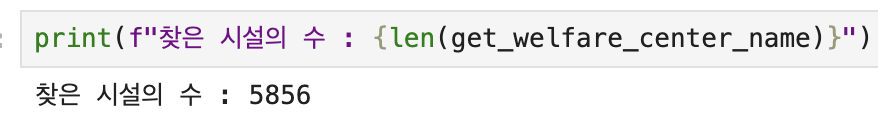

### 복지센터 파일로 저장하기 위한 프레임워크화

In [ ]:
welfare_center_df = pd.DataFrame({
    '구분' : get_welfare_center_classification, 
    '시설명' : get_welfare_center_name, 
    '위치' : get_welfare_center_x_y_location,
    '위도' : get_welfare_center_x,
    '경도' : get_welfare_center_y
})

In [ ]:
welfare_center_df.head()

### 학교 위치를 csv 파일로 저장

In [ ]:
school_df.to_csv(f'{save_file_folder}/서울시_학교_위치.csv', encoding = sava_file_encoding)

### 아동센터 위치를 csv 파일로 저장

In [ ]:
children_df.to_csv(f'{save_file_folder}/서울시_아동센터_위치.csv', encoding = sava_file_encoding)

### 어린이집 위치를 csv 파일로 저장

In [ ]:
children_care_df.to_csv(f'{save_file_folder}/서울시_어린이집_위치.csv', encoding = sava_file_encoding)

### 복지센터 위치를 csv 파일로 저장

In [ ]:
welfare_center_df.to_csv(f'{save_file_folder}/서울시_복지센터_위치.csv', encoding = sava_file_encoding)

### 통합 파일로 저장하기 위한 데이터값 저장

In [ ]:
print(f"통합구분 길이 : {len(all_list_classification)}")
print(f"통합좌표 길이 : {len(all_list_location_x_y)}")
print(f"위도좌표 길이 : {len(all_list_location_x)}")
print(f"경도좌표 길이 : {len(all_list_location_y)}")
print(f"통합이름 길이 : {len(all_list_name)}")

In [ ]:
# 통합 파일에 학교 정보를 저장
for i in range(len(get_school_name)) :
    all_list_classification.append('학교')
    all_list_location_x_y.append(get_school_location_x_y[i])
    all_list_name.append(get_school_name[i])
    all_list_location_x.append(get_school_location_x[i])
    all_list_location_y.append(get_school_location_y[i])

In [ ]:
print(f"통합구분 길이 : {len(all_list_classification)}")
print(f"통합좌표 길이 : {len(all_list_location_x_y)}")
print(f"위도좌표 길이 : {len(all_list_location_x)}")
print(f"경도좌표 길이 : {len(all_list_location_y)}")
print(f"통합이름 길이 : {len(all_list_name)}")

In [ ]:
# 통합 파일에 아동센터 정보를 저장
for i in range(len(get_children_center_name)) :
    all_list_classification.append('아동센터')
    all_list_name.append(get_children_center_name[i])
    all_list_location_x_y.append(get_children_center_x_y_location[i])
    all_list_location_x.append(get_children_center_x[i]) 
    all_list_location_y.append(get_children_center_y[i]) 
    

In [ ]:
print(f"통합구분 길이 : {len(all_list_classification)}")
print(f"통합좌표 길이 : {len(all_list_location_x_y)}")
print(f"위도좌표 길이 : {len(all_list_location_x)}")
print(f"경도좌표 길이 : {len(all_list_location_y)}")
print(f"통합이름 길이 : {len(all_list_name)}")

In [ ]:
# 통합 파일에 어린이집 정보를 저장
for i in range(len(get_children_care_name)) :
    all_list_classification.append('어린이집')
    all_list_name.append(get_children_care_name[i])
    all_list_location_x_y.append(get_children_care_location_x_y[i])
    all_list_location_x.append(get_children_care_location_x[i]) 
    all_list_location_y.append(get_children_care_location_y[i]) 
    

In [ ]:
print(f"통합구분 길이 : {len(all_list_classification)}")
print(f"통합좌표 길이 : {len(all_list_location_x_y)}")
print(f"위도좌표 길이 : {len(all_list_location_x)}")
print(f"경도좌표 길이 : {len(all_list_location_y)}")
print(f"통합이름 길이 : {len(all_list_name)}")

In [ ]:
# 통합 파일에 복지센터 정보를 저장
for i in range(len(get_welfare_center_name)) :
    all_list_classification.append('복지센터')
    all_list_name.append(get_welfare_center_name[i])
    all_list_location_x_y.append(get_welfare_center_x_y_location[i])
    all_list_location_x.append(get_welfare_center_x[i]) 
    all_list_location_y.append(get_welfare_center_y[i]) 

In [ ]:
print(f"통합구분 길이 : {len(all_list_classification)}")
print(f"통합좌표 길이 : {len(all_list_location_x_y)}")
print(f"위도좌표 길이 : {len(all_list_location_x)}")
print(f"경도좌표 길이 : {len(all_list_location_y)}")
print(f"통합이름 길이 : {len(all_list_name)}")

### 통합 데이터 파일을 csv 파일로 저장

In [ ]:
# 통합 데이터 저장

all_list_df = pd.DataFrame({
    '시설_구분' : all_list_classification,
    '시설_이름' : all_list_name,
    '시설_위치' : all_list_location_x_y,
    '위도' : all_list_location_x,
    '경도' : all_list_location_y
})

all_list_df.to_csv(f'{folder_name_2}/서울시_모든_시설의_위치.csv', encoding = sava_file_encoding)

In [ ]:
print(f'시스템 종료')